# Binance Options: Pricing & Greeks - Hands-On Tutorial

This notebook demonstrates **three classic methods** for European option pricing - **Black-Scholes**, **Binomial (CRR)**, and **Monte Carlo** - then applies them to **Binance options** data (live if available, else a bundled sample).  
We also **back out implied vol**, build an **IV smile**, and **validate Greeks**.

> **Note**: The notebook can run fully offline using sample data. To switch to **live Binance** data, set `USE_LIVE = True` in the config cell below and ensure your environment has outbound internet.

## 0) Environment

You'll need Python 3.10+, plus: `numpy`, `pandas`, `matplotlib`, and `requests`.  
If you're running this in a fresh environment, install with:

```bash
pip install -r requirements.txt
```

In [31]:

# 1) Imports & Config
import os, sys, json, math, time, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# local imports
sys.path.append("src")
from option_math import bs_price, bs_greeks, implied_vol_bisect, crr_binomial_price, mc_price, parse_binance_symbol, year_fraction
from binance_adapter import exchange_info, mark, index_price, load_sample_mark_data

# ---- Toggle live data here ----
USE_LIVE = True           # set True to fetch from Binance
UNDERLYING = "BTCUSDT"      # for index price
SAMPLE_PATH = "data/sample_mark_data.json"
EXPIRY_FILTER = None        # e.g., "250920" to filter a specific expiry (YYMMDD). None = any


In [32]:

# 2) Load Data (Live -> fallback to sample)
def load_data() -> pd.DataFrame:
    if USE_LIVE:
        try:
            info = exchange_info()  # GET /eapi/v1/exchangeInfo
            # pick BTC options
            syms = [s for s in info["optionSymbols"] if s.get("underlying") == UNDERLYING]
            # optional expiry filter
            if EXPIRY_FILTER:
                syms = [s for s in syms if EXPIRY_FILTER in s["symbol"]]
            # fetch mark data for all symbols in chunks
            # If you hit rate limits, consider batching or querying per expiry
            marks = mark()  # GET /eapi/v1/mark  (all symbols)
            df_m = pd.DataFrame(marks)
            # narrow to symbols we saw in exchangeInfo (safer)
            df_m = df_m[df_m["symbol"].isin([s["symbol"] for s in syms])].copy()
            # get index (spot) price for UNDERLYING
            idx = index_price(UNDERLYING)     # GET /eapi/v1/index
            spot = float(idx.get("indexPrice") or idx.get("price") or np.nan)
            return df_m, spot
        except Exception as e:
            print("Live fetch failed; falling back to sample. Reason:", repr(e))
    # offline fallback
    sample = load_sample_mark_data(SAMPLE_PATH)
    df_m = pd.DataFrame(sample)
    # use a rough spot from symbols (~ATM strike), or default
    spot_guess = 65000.0
    return df_m, spot_guess

df_raw, spot = load_data()
print("Loaded rows:", len(df_raw), "| spot =", spot)
df_raw.head()


Loaded rows: 404 | spot = 91165.84956522


,symbol,markPrice,bidIV,askIV,markIV,delta,theta,gamma,vega,highPriceLimit,lowPriceLimit,riskFreeInterest
0,BTC-260327-100000-C,4254.996,0.42628169,0.42752624,0.42752624,0.37733795,-43.66303921,0.00002104,160.68366034,7658.993,850.999,0.0504
1,BTC-260327-120000-C,1009.999,0.44390798,0.44450104,0.44390798,0.1192322,-23.81284217,0.0000106,84.22018881,1817.999,201.999,0.0504
2,BTC-260327-90000-C,8362.387,0.43413043,0.43959379,0.43518621,0.58644974,-45.81118686,0.00002108,164.74608589,15052.297,1672.477,0.0504
3,BTC-260327-200000-C,42.881,0.60955703,0.63866556,0.62221113,0.00554472,-2.66345833,0.00000060,6.70458351,77.186,8.576,0.0504
4,BTC-260327-100000-P,12064.988,0.43092489,0.43589354,0.43092489,-0.62112808,-44.38395056,0.00002075,160.88507475,21716.978,2412.997,0.0504


In [33]:

# 3) Tidy / parse & compute time to expiry
def parse_symbol_row(sym: str):
    base, expiry, K, opt = parse_binance_symbol(sym)
    return base, expiry, float(K), opt

def compute_T(expiry: datetime.date) -> float:
    now = datetime.datetime.utcnow().timestamp()
    exp_ts = datetime.datetime(expiry.year, expiry.month, expiry.day, 8, 0).timestamp()  # assume 08:00 UTC settlement
    return year_fraction(now, exp_ts)

df = df_raw.copy()
# ensure numeric fields
for col in ["markPrice", "bidIV", "askIV", "markIV", "delta", "theta", "gamma", "vega", "riskFreeInterest"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

parsed = df["symbol"].apply(parse_symbol_row)
df["base"] = parsed.apply(lambda t: t[0])
df["expiry"] = parsed.apply(lambda t: t[1])
df["K"] = parsed.apply(lambda t: t[2])
df["opt"] = parsed.apply(lambda t: t[3])

df["T"] = df["expiry"].apply(compute_T).clip(lower=1e-6)
df["r"] = np.where(df["riskFreeInterest"].notna(), df["riskFreeInterest"].astype(float), 0.05)
df["q"] = 0.0  # no dividend yield for BTC/ETH

df.sort_values(["expiry", "K", "opt"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


/var/folders/8t/py7199996lzcf46ws17_9lp80000gn/T/ipykernel_41135/2074403356.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow().timestamp()


,symbol,markPrice,bidIV,askIV,markIV,delta,theta,gamma,vega,highPriceLimit,lowPriceLimit,riskFreeInterest,base,expiry,K,opt,T,r,q
0,BTC-260108-86000-C,5178.142,6.000000e-07,-1.000000,0.611300,0.993226,-39.507528,0.000008,0.671174,9320.656,1035.628,0.0575,BTC,2026-01-08,86000.0,C,0.001513,0.0575,0.0
1,BTC-260108-86000-P,6.580,-1.000000e+00,0.669996,0.634800,-0.008690,-66.985201,0.000008,0.835805,11.844,5,0.0575,BTC,2026-01-08,86000.0,P,0.001513,0.0575,0.0
2,BTC-260108-88000-C,3195.548,6.000000e-07,-1.000000,0.494300,0.968028,-149.696156,0.000031,2.543113,5751.987,639.109,0.0575,BTC,2026-01-08,88000.0,C,0.001513,0.0575,0.0
3,BTC-260108-88000-P,17.853,4.633397e-01,0.486023,0.476768,-0.027429,-96.263505,0.000038,2.239381,32.136,5,0.0575,BTC,2026-01-08,88000.0,P,0.001513,0.0575,0.0
4,BTC-260108-89000-C,2228.554,6.000000e-07,-1.000000,0.439400,0.922279,-303.566113,0.000063,5.157132,4011.398,445.71,0.0575,BTC,2026-01-08,89000.0,C,0.001513,0.0575,0.0


## 1) Black-Scholes pricing & consistency check

We'll re-price each quote using Black-Scholes with `markIV` and compare to `markPrice` to see how close Binance's **mark** is to the model value.

In [34]:

def bs_from_row(S, row):
    return bs_price(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])

df["bs_mark"] = df.apply(lambda r: bs_from_row(spot, r), axis=1)
df["bs_err"] = df["bs_mark"] - df["markPrice"]
df[["symbol", "markPrice", "markIV", "bs_mark", "bs_err"]].head(10)


,symbol,markPrice,markIV,bs_mark,bs_err
0,BTC-260108-86000-C,5178.142,0.611300,5178.142334,0.000334
1,BTC-260108-86000-P,6.580,0.634800,6.580221,0.000221
2,BTC-260108-88000-C,3195.548,0.494300,3195.546398,-0.001602
3,BTC-260108-88000-P,17.853,0.476768,17.851994,-0.001006
4,BTC-260108-89000-C,2228.554,0.439400,2228.551228,-0.002772
5,BTC-260108-89000-P,43.439,0.415762,43.436378,-0.002622
6,BTC-260108-90000-C,1304.099,0.369597,1304.095565,-0.003435
7,BTC-260108-90000-P,135.000,0.374461,134.996024,-0.003976
8,BTC-260108-91000-C,590.000,0.352613,589.995072,-0.004928
9,BTC-260108-91000-P,424.999,0.358874,424.994753,-0.004247


## 2) Implied volatility (from price)

Now invert Black–Scholes to recover **implied volatility** from the observed `markPrice` and compare to the quoted `markIV`.

In [35]:

def impvol_from_row(S, row):
    return implied_vol_bisect(row["markPrice"], S, row["K"], row["r"], row["q"], row["T"], row["opt"])

df["iv_backed"] = df.apply(lambda r: impvol_from_row(spot, r), axis=1)
df["iv_diff"] = df["iv_backed"] - df["markIV"]
df[["symbol","markIV","iv_backed","iv_diff"]].head(10)


,symbol,markIV,iv_backed,iv_diff
0,BTC-260108-86000-C,0.611300,0.611295,-0.000005
1,BTC-260108-86000-P,0.634800,0.634797,-0.000003
2,BTC-260108-88000-C,0.494300,0.494306,0.000006
3,BTC-260108-88000-P,0.476768,0.476773,0.000004
4,BTC-260108-89000-C,0.439400,0.439405,0.000005
5,BTC-260108-89000-P,0.415762,0.415768,0.000006
6,BTC-260108-90000-C,0.369597,0.369601,0.000004
7,BTC-260108-90000-P,0.374461,0.374466,0.000004
8,BTC-260108-91000-C,0.352613,0.352616,0.000004
9,BTC-260108-91000-P,0.358874,0.358877,0.000003


## 3) IV smile for one expiry

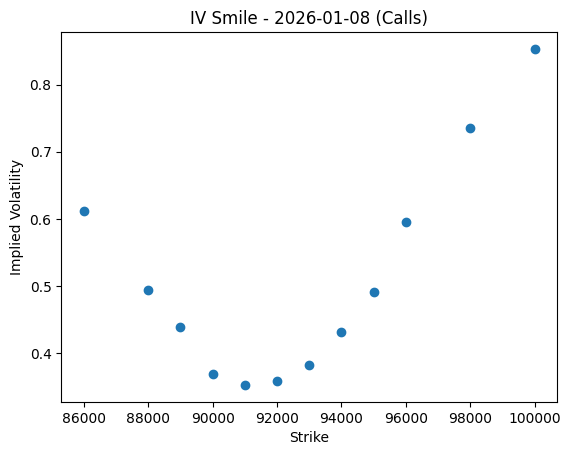

In [36]:

# pick the nearest expiry
first_expiry = df["expiry"].min()
dfe = df[df["expiry"] == first_expiry].copy()
dfe_calls = dfe[dfe["opt"] == "C"].copy()

plt.figure()
plt.scatter(dfe_calls["K"], dfe_calls["iv_backed"])
plt.title(f"IV Smile - {first_expiry} (Calls)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.show()


## 4) Greeks check (our formulas vs Binance)

We compute Greeks using our Black–Scholes functions and compare to Binance’s reported greeks from `/eapi/v1/mark`.

In [37]:

def our_greeks_from_row(S, row):
    return bs_greeks(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])

sample_row = dfe.iloc[len(dfe)//2]  # a mid-strike row
g = our_greeks_from_row(spot, sample_row)

compare = {
    "symbol": sample_row["symbol"],
    "delta_binance": sample_row.get("delta", np.nan),
    "delta_ours": g["delta"],
    "gamma_binance": sample_row.get("gamma", np.nan),
    "gamma_ours": g["gamma"],
    "theta_binance": sample_row.get("theta", np.nan),
    "theta_ours": g["theta"],
    "vega_binance": sample_row.get("vega", np.nan),
    "vega_ours": g["vega"],
}
pd.DataFrame([compare])


,symbol,delta_binance,delta_ours,gamma_binance,gamma_ours,theta_binance,theta_ours,vega_binance,vega_ours
0,BTC-260108-93000-C,0.092415,0.092412,0.000124,0.000122,-200.464475,-74702.369582,5.8721,587.189063


## 5) Binomial (CRR) vs Black–Scholes

In [38]:

row = sample_row
bs = bs_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])
b100 = crr_binomial_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], 100, row["opt"])
b500 = crr_binomial_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], 500, row["opt"])
pd.DataFrame([{"symbol": row["symbol"], "BS": bs, "CRR N=100": b100, "CRR N=500": b500}])


,symbol,BS,CRR N=100,CRR N=500
0,BTC-260108-93000-C,58.034846,58.117083,57.878233


## 6) Monte Carlo cross‑check

In [39]:

mc = mc_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], n_paths=200_000, opt=row["opt"])
pd.DataFrame([{"symbol": row["symbol"], "Black-Scholes": bs, "Monte Carlo (200k)": mc, "Diff": mc - bs}])


,symbol,Black-Scholes,Monte Carlo (200k),Diff
0,BTC-260108-93000-C,58.034846,59.222862,1.188016


## 7) Scenario: price vs underlying

Hold IV and time fixed; vary the underlying ±20% to see the option price sensitivity.

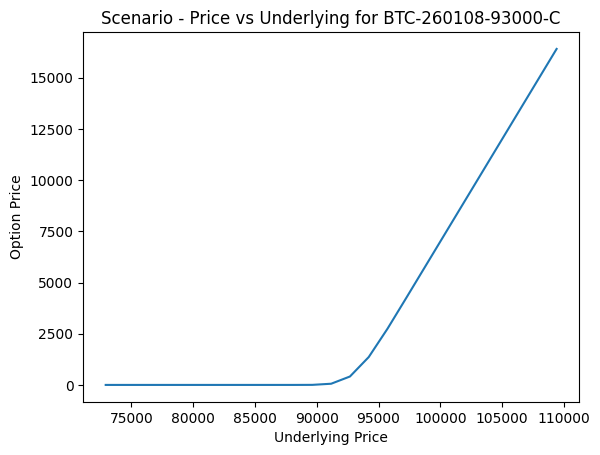

In [40]:

Ss = np.linspace(0.8 * spot, 1.2 * spot, 25)
prices = [bs_price(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"]) for S in Ss]

plt.figure()
plt.plot(Ss, prices)
plt.title(f"Scenario - Price vs Underlying for {row['symbol']}")
plt.xlabel("Underlying Price")
plt.ylabel("Option Price")
plt.show()


---

### References

- **Option Mark Price**: `GET /eapi/v1/mark` - returns mark price, IVs, and Greeks.
- **Exchange Information**: `GET /eapi/v1/exchangeInfo` - list of symbols, filters.
- **Index (Spot) Price for Underlying**: `GET /eapi/v1/index` - spot index of the underlying.

See Binance Options API docs.